In [1]:
import numpy as np
import os
from Utils.utilities import *
import h5py
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from models.cnn2d_lstm import CNN2D_LSTM_Net

In [2]:
set_seed(42) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Use os.path.join() to create the correct file path
filepath = get_filepath()
print(f"Base filepath: {filepath}")

# Example usage for Intra-subject classification
intra_train_path = os.path.join(filepath, "Intra", "train")
intra_test_path = os.path.join(filepath, "Intra", "test")

# Load a small subset of files to test the function
# Downsample factor is set to 16 to speed up the process, CHANGE LATER!
train_raw, train_labels = load_h5_files(intra_train_path)
test_raw, test_labels = load_h5_files(intra_test_path)

train_data = normalize_meg_data(train_raw, downsample_factor=4)
test_data = normalize_meg_data(test_raw, downsample_factor=4)

Base filepath: c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\Final Project data\Final Project data


In [5]:
# Check training set size and distribution
print(f"Training samples: {len(train_data)}")
print(f"Training label distribution:")
for label in set(train_labels):
    count = train_labels.count(label)
    print(f"  {label}: {count}")

print(f"\nTest samples: {len(test_data)}")
print(f"Test label distribution:")
for label in set(test_labels):
    count = test_labels.count(label)
    print(f"  {label}: {count}")

Training samples: 32
Training label distribution:
  task_story: 8
  task_working: 8
  task_motor: 8
  rest: 8

Test samples: 8
Test label distribution:
  task_story: 2
  task_working: 2
  task_motor: 2
  rest: 2


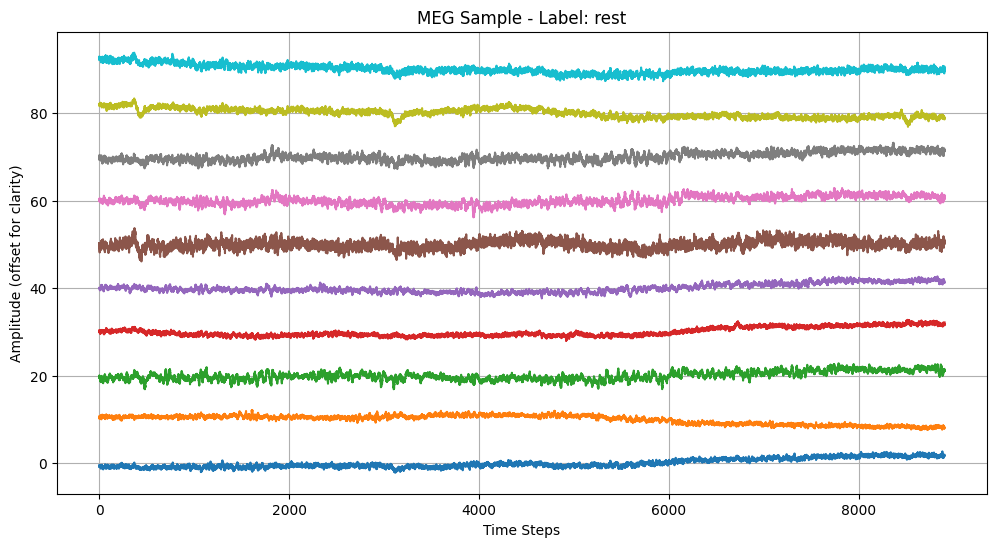

In [6]:
plot_meg_sample(train_data[0], train_labels[0])

In [7]:
# Standard class mapping for MEG tasks

LABEL_MAP = {
    'rest': 0,
    'task_motor': 1, 
    'task_story': 2,
    'task_working': 3
}

In [8]:
class MEGNet(nn.Module):
    """Smaller 2D CNN for MEG data classification"""

    #I WOULD ADD L2 NORMALIZATION HERE

    def __init__(self, num_classes=4, input_channels=248, input_time_steps=2227):
        super(MEGNet, self).__init__()
        
        # Smaller conv blocks
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(8, 16), padding=(4, 8))
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 8))  # More aggressive pooling
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(4, 8), padding=(2, 4))
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 8))  # More aggressive pooling
        
        # Calculate the size after convolutions
        self.flatten_size = self._calculate_flatten_size(input_channels, input_time_steps)
        
        # Smaller fully connected layers
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def _calculate_flatten_size(self, channels, time_steps):
        """Calculate the size after all conv+pool operations"""
        # Simulate forward pass to get dimensions
        x = torch.zeros(1, 1, channels, time_steps)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        return x.numel()
    
    def forward(self, x):
        # Conv blocks with ReLU and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Flatten for fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
class TinyMEGNet(nn.Module):
    """Very small CNN for limited MEG data"""
    def __init__(self, num_classes=4, input_channels=248, input_time_steps=2227):
        super(TinyMEGNet, self).__init__()
        
        # Aggressive downsampling with minimal parameters
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(32, 64), stride=(8, 16))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(4, 8), stride=(2, 4))
        
        # Global average pooling instead of large FC layers
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Minimal fully connected
        self.fc = nn.Linear(8, num_classes)
        self.dropout = nn.Dropout(0.5)
        
        print(f"TinyMEGNet created with {sum(p.numel() for p in self.parameters()):,} parameters")
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        return x    


class CNN_LSTM_Net(nn.Module):
    """
    Hybrid CNN + LSTM model for MEG classification.

    Architecture:
    1. CNN layers extract spatial features from MEG sensors.
    2. Reshape CNN output to form a temporal sequence.
    3. LSTM models the sequence over time.
    4. Fully connected classifier makes predictions.
    """

    def __init__(self, num_classes=4, input_sensors=248, input_time_steps=2227,
                 lstm_hidden_size=64, num_lstm_layers=2, dropout=0.3):
        super(CNN_LSTM_Net, self).__init__()

        self.input_sensors = input_sensors
        self.input_time_steps = input_time_steps

        # Step 1: Spatial CNN layers (learn spatial patterns across sensors)
        self.spatial_conv = nn.Sequential(
            # Reduce number of spatial (sensor) rows while keeping time dimension intact
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(16, 1), stride=(4, 1), padding=(6, 0)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout),

            nn.Conv2d(16, 32, kernel_size=(8, 1), stride=(2, 1), padding=(3, 0)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout),

            nn.Conv2d(32, 64, kernel_size=(4, 1), stride=(2, 1), padding=(1, 0)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Calculate the total spatial feature dimension after the conv stack
        self._calculate_spatial_output_size()

        # Step 2: Temporal Conv1D layers to process across time
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(self.flattened_spatial_dim, 128, kernel_size=16, stride=8, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(128, 64, kernel_size=8, stride=4, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self._calculate_temporal_output_size()

        # Step 3: LSTM for modeling sequential dynamics over time
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0,
            bidirectional=True
        )

        # Step 4: Fully connected classifier
        lstm_output_size = lstm_hidden_size * 2  # bidirectional doubles output
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_size, lstm_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size, num_classes)
        )

        print(f"CNNLSTMNet created with {sum(p.numel() for p in self.parameters()):,} parameters")
        print(f"  - Flattened spatial features per time step: {self.flattened_spatial_dim}")
        print(f"  - Temporal sequence length after temporal convs: {self.temporal_length}")
        print(f"  - LSTM output dim per time step: {lstm_output_size}")

    def _calculate_spatial_output_size(self):
        # Simulate input to compute spatial conv output shape
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.input_sensors, self.input_time_steps)
            x = self.spatial_conv(dummy_input)
            _, conv_channels, reduced_sensors, _ = x.shape
            self.flattened_spatial_dim = conv_channels * reduced_sensors  # for Conv1D

    def _calculate_temporal_output_size(self):
        """Simulate a forward pass through temporal_conv to compute output sequence length."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.flattened_spatial_dim, self.input_time_steps)
            output = self.temporal_conv(dummy_input)
            self.temporal_length = output.shape[2]  # length after Conv1D

    def forward(self, x):
        batch_size = x.size(0)  # x: (B, 1, sensors=248, time_steps)

        # Step 1: Spatial conv
        x = self.spatial_conv(x)  # → (B, conv_channels=64, reduced_sensors, time_steps)

        # Step 2: Flatten spatial dims (channels × sensors) → one feature vector per time step
        x = x.view(batch_size, self.flattened_spatial_dim, -1)  # → (B, flattened_spatial, time_steps)

        # Step 3: Temporal conv
        x = self.temporal_conv(x)  # → (B, 64, temporal_length)

        # Step 4: Prepare for LSTM: transpose to (B, sequence_len, features)
        x = x.transpose(1, 2)  # → (B, temporal_length, 64)

        # Step 5: LSTM
        lstm_out, _ = self.lstm(x)  # → (B, temporal_length, 128)

        # Step 6: Use the final time step (last one) for classification
        x = lstm_out[:, -1, :]  # → (B, 128)

        # Step 7: Classifier
        out = self.classifier(x)  # → (B, num_classes)
        
        return out

In [9]:
# net = CNN_LSTM_Net(num_classes=len(LABEL_MAP), 
#                           input_sensors=248, 
#                           input_time_steps=train_data[0].shape[1])
# model_save_path = 'intra_cnn_lstm_model.pth'
# print(f"Model created. Total parameters: {sum(p.numel() for p in net.parameters()):,}")
# print(f"Model input shape expected: (batch, 1, 248, {train_data[0].shape[1]})")

In [10]:
model_Tiny_fn = lambda: TinyMEGNet(
    num_classes=len(LABEL_MAP),
    input_channels=248,
    input_time_steps=train_data[0].shape[1]
)

model_CNN_LSTM_fn = lambda: CNN_LSTM_Net(
    num_classes=len(LABEL_MAP),
    input_sensors=248,
    input_time_steps=train_data[0].shape[1]
)

CNN2D_LSTM_Net_fn = lambda: CNN2D_LSTM_Net(
    num_classes=len(LABEL_MAP),
    input_sensors=248,
    input_time_steps=train_data[0].shape[1]
)

In [11]:
# Run Experiment (cross-validation or train/val/test split)
fold_results, all_histories = cross_validation_experiment(
    all_data=train_data,
    all_labels=train_labels,
    label_map=LABEL_MAP,
    model_fn=CNN2D_LSTM_Net_fn,
    n_splits=4, 
    epochs=50, 
    batch_size=4
)


  CROSS-VALIDATION EXPERIMENT (4 folds)
Total samples: 32
Samples per fold - Train: ~24, Val: ~8

--- FOLD 1/4 ---
2D CNN + LSTM Net initialized:
  - LSTM input size: 3968
  - Sequence length: 594
  - Parameters: 2,269,700
Epoch  0: Train Acc=0.250, Val Acc=0.250, Val Loss=1.385
Epoch 10: Train Acc=0.750, Val Acc=0.625, Val Loss=0.785
Early stopping at epoch 14
Fold 1 Best Val Accuracy: 0.6250

--- FOLD 2/4 ---
2D CNN + LSTM Net initialized:
  - LSTM input size: 3968
  - Sequence length: 594
  - Parameters: 2,269,700
Epoch  0: Train Acc=0.208, Val Acc=0.250, Val Loss=1.382
Epoch 10: Train Acc=0.792, Val Acc=0.500, Val Loss=0.913
Early stopping at epoch 16
Fold 2 Best Val Accuracy: 0.6250

--- FOLD 3/4 ---
2D CNN + LSTM Net initialized:
  - LSTM input size: 3968
  - Sequence length: 594
  - Parameters: 2,269,700
Epoch  0: Train Acc=0.375, Val Acc=0.000, Val Loss=1.388
Epoch 10: Train Acc=0.792, Val Acc=0.375, Val Loss=1.184
Epoch 20: Train Acc=0.833, Val Acc=0.375, Val Loss=2.058
Early


  CROSS-VALIDATION RESULTS SUMMARY

Best Validation Accuracies per Fold:
  Fold 1: 0.6250 (62.50%)
  Fold 2: 0.6250 (62.50%)
  Fold 3: 0.6250 (62.50%)
  Fold 4: 0.6250 (62.50%)

Cross-Validation Summary:
  Mean Accuracy: 0.6250 ± 0.0000
  Best Fold: 0.6250
  Worst Fold: 0.6250


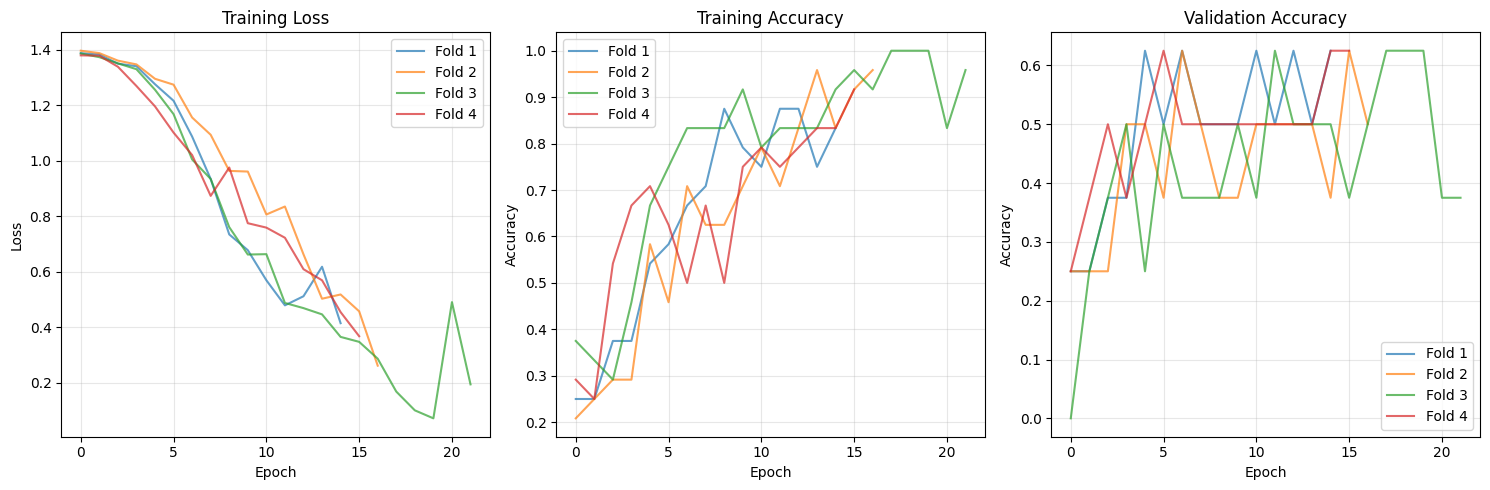

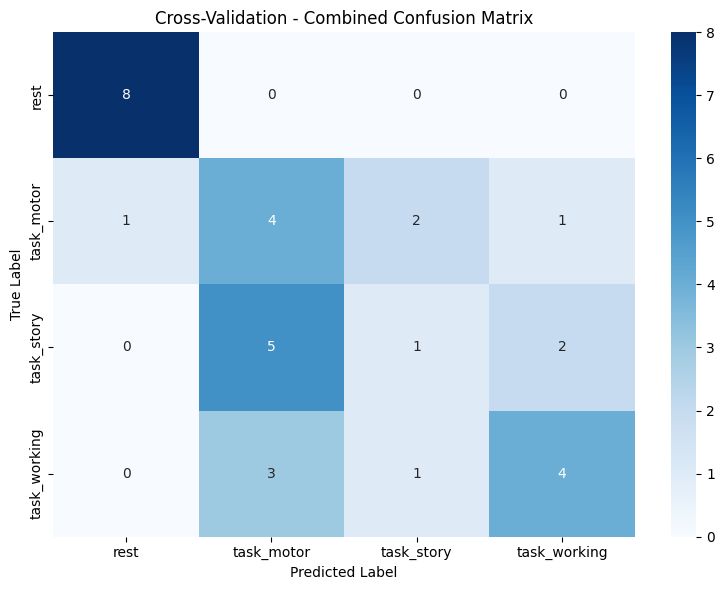

In [12]:
# Analyze results
mean_acc, std_acc = analyze_cv_results(fold_results, all_histories, LABEL_MAP)